In [66]:
!pip install seaborn sklearn miceforest catboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [1]:
#standard
import re
from collections import Counter

#3rd party
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import miceforest as mf

import catboost

#local
from configs import DATA_PATH

SEED = 1998
np.random.seed(SEED)

# Load data

In [2]:
data = pd.read_csv(DATA_PATH, index_col=0)
# data = data.drop(columns="void()")
# print(len(data))
# data = data.dropna()
print(len(data))

11086


In [3]:
# data.columns = [re.sub("\(\)", "", column) for column in data.columns]
# data.columns = [re.sub("\-|\,", "_", column) for column in data.columns]

data[["Activity", "subject"]] = data[["Activity", "subject"]].astype("category")

In [4]:
X, y = data.iloc[:,1:], data.iloc[:,0]
indices = np.random.randint(0, len(X), )
X_sample = X.sample(frac=0.25)
y_sample = y[X_sample.index.tolist()]

In [48]:
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in data.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,82
fBodyGyro,79
fBodyAccJerk,79
tBodyGyro,43
tGravityAcc,40
tBodyGyroJerk,40
tBodyAccJerk,40
tBodyAcc,40
tBodyAccMag,13
tBodyAccJerkMag,13


In [49]:
a = data["Activity"].value_counts()

In [50]:
data["void()"].unique()

array([ 1.,  2.,  3., nan])

As we can see void() is almost uniformly distributed for some of the activities.

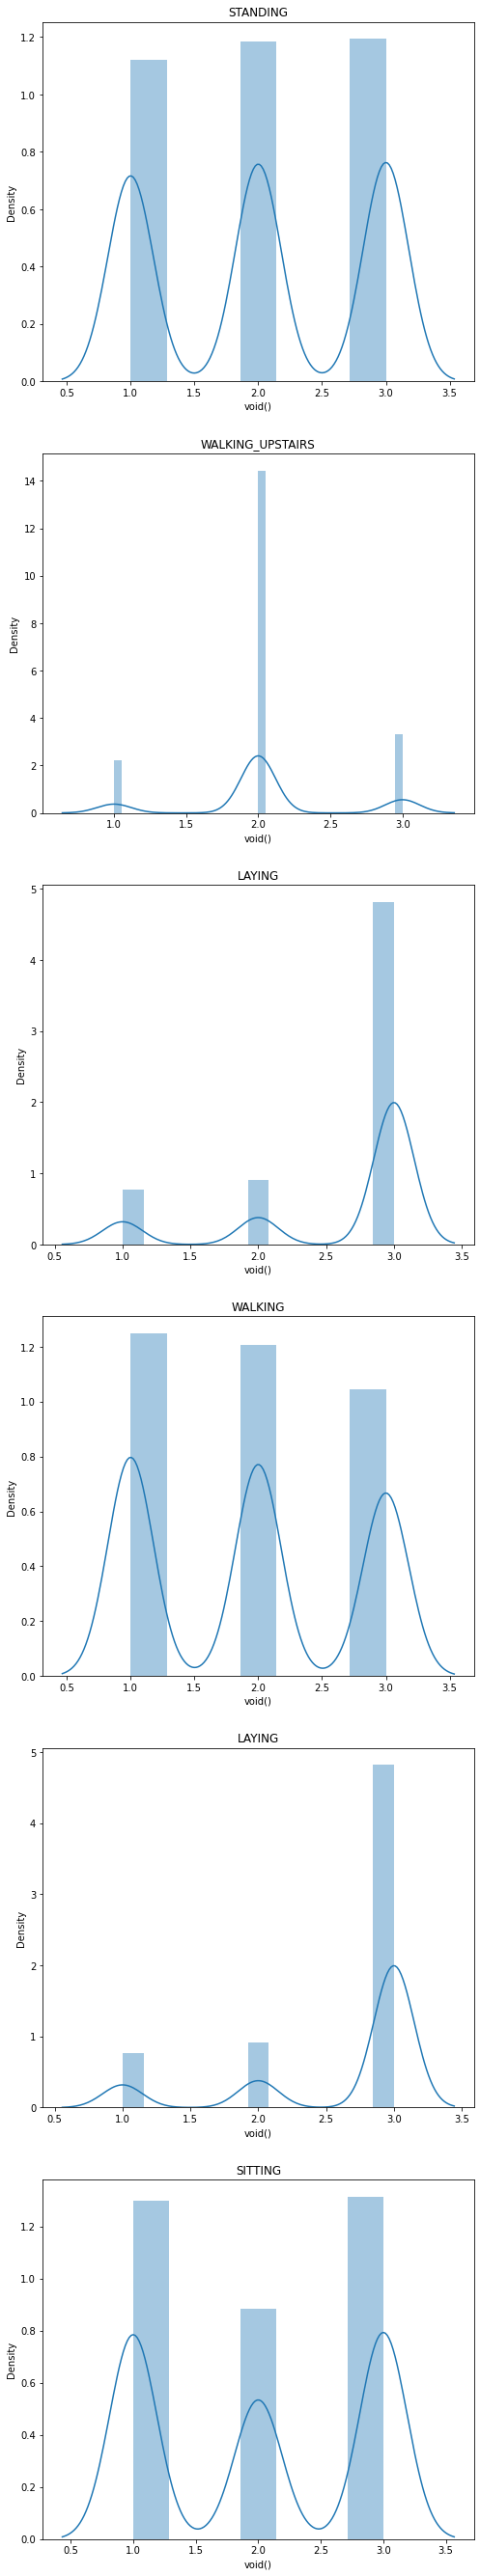

In [51]:
n = data["Activity"].nunique()
fig, ax = plt.subplots(n, 1, figsize=(8, n*8))
for axi, actv in zip(ax, data["Activity"]):
    sns.distplot(data.loc[data["Activity"]==actv, "void()"], ax=axi, kde=True)
    axi.set_title(actv)
    
plt.show()    

In [5]:
X.drop(columns="void()", inplace=True)

# Exploratory data analysis

Nans checkout

In [6]:
X.isna().sum().sort_values(ascending=False)

fBodyGyro-bandsEnergy()-33,48    84
fBodyAcc-bandsEnergy()-49,56     79
tBodyAccMag-sma()                77
fBodyAccJerk-std()-Y             77
tBodyGyro-std()-X                76
                                 ..
tGravityAccMag-entropy()         41
tGravityAcc-std()-X              40
fBodyAcc-main()-Z                39
fBodyAcc-entropy()-Y             38
subject                           0
Length: 570, dtype: int64

In [54]:
nans_sorted = X.T.isna().sum().sort_values(ascending=False)
nans_sorted[nans_sorted > 0]

5397    40
3536    40
8866    40
692     40
6220    40
        ..
6118     5
8317     5
8808     5
1654     5
8877     4
Length: 1462, dtype: int64

In [58]:
idx = nans_sorted[nans_sorted == 40].index[0]

In [32]:
X.loc[6220, :]

angle(X_gravityMean)                   -1.574029
angle(Y_gravityMean)                   -0.766164
angle(Z_gravityMean)                   -2.446730
angle(tBodyAccJerkMean)_gravityMean)   -1.949025
angle(tBodyAccMean_gravity)            -0.113787
                                          ...   
tGravityAccMag_mean                    -0.809719
tGravityAccMag_min                     -0.478636
tGravityAccMag_sma                      0.722631
tGravityAccMag_std                     -0.668744
void                                    3.000000
Name: 6220, Length: 571, dtype: float64

Missing data imputation

Cardinality checkout

In [8]:
data["Activity"].unique()

['STANDING', 'WALKING_UPSTAIRS', 'LAYING', 'WALKING', 'SITTING', 'WALKING_DOWNSTAIRS']
Categories (6, object): ['STANDING', 'WALKING_UPSTAIRS', 'LAYING', 'WALKING', 'SITTING', 'WALKING_DOWNSTAIRS']

In [10]:
pd.DataFrame(X.nunique().sort_values(ascending=False)).T

,energy_mean,tBodyGyro_low_Y,tGravityAccMag_sma,fBodyAcc_main_Z,tGravityAccMag_mad,tBodyGyro_correlation_X_Y,tBodyGyro_arCoeff_Z_4,tBodyGyro_arCoeff_Z_3,tBodyGyro_arCoeff_Z_2,tBodyGyro_arCoeff_Z_1,tBodyGyro_arCoeff_Y_2,tBodyGyro_arCoeff_Y_1,tBodyGyro_arCoeff_X_4,tBodyGyro_arCoeff_X_3,tBodyGyro_arCoeff_X_2,fBodyBodyGyroJerkMag_meanFreq,angle(X_gravityMean),tBodyGyro_correlation_X_Z,tBodyAccMag_arCoeff4,tBodyAccMag_arCoeff3,tBodyAccMag_arCoeff2,tBodyAccMag_arCoeff1,fBodyBodyGyroMag_kurtosis,fBodyBodyGyroMag_mad,fBodyBodyGyroMag_meanFreq,fBodyBodyGyroMag_skewness,tBodyAccJerkMag_arCoeff4,tBodyAccJerkMag_arCoeff3,tBodyAccJerkMag_arCoeff2,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,tBodyGyro_correlation_Y_Z,tBodyGyro_mean_Z,tBodyGyroJerk_arCoeff_Z_1,tBodyGyroJerk_arCoeff_Y_4,tBodyGyroJerk_arCoeff_Y_3,tBodyGyroJerk_arCoeff_X_4,tBodyGyroJerk_arCoeff_X_3,tBodyGyroJerk_arCoeff_X_2,tBodyGyro_std_Z,fBodyAccMag_meanFreq,tBodyGyro_sma,fBodyAccMag_skewness,tBodyGyro_mean_Y,fBodyGyro_kurtosis_X,tBodyAcc_arCoeff_Z_2,fBodyAccMag_std,fBodyBodyAccJerkMag_kurtosis,tBodyGyro_mad_X,tBodyGyro_low_Z,tBodyGyro_low_X,fBodyBodyAccJerkMag_mad,fBodyBodyAccJerkMag_meanFreq,fBodyBodyAccJerkMag_skewness,fBodyBodyAccJerkMag_std,tBodyAccJerkMag_arCoeff1,tBodyAccJerk_mean_Z,fBodyGyro_kurtosis_Y,tBodyAcc_arCoeff_X_2,tBodyAcc_sma,fBodyGyro_skewness_Y,fBodyGyro_skewness_Z,fBodyGyro_sma,tBodyAcc_mean_Z,tBodyAcc_mean_Y,shadow_gravity_angle,tBodyAcc_mad_Z,tBodyAcc_mad_Y,tBodyAcc_arCoeff_X_1,tBodyAcc_arCoeff_X_3,fBodyGyro_skewness_X,tBodyAcc_arCoeff_X_4,tBodyAcc_arCoeff_Y_1,tBodyAcc_arCoeff_Y_2,tBodyAcc_arCoeff_Y_3,tBodyAcc_arCoeff_Y_4,tBodyAcc_arCoeff_Z_1,tBodyAcc_correlation_Y_Z,tBodyAcc_correlation_X_Z,tBodyAcc_correlation_X_Y,tBodyAcc_arCoeff_Z_4,tBodyAcc_std_X,tBodyAcc_std_Z,tBodyGyroJerk_arCoeff_Z_4,tBodyAccJerk_correlation_X_Y,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_X,fBodyGyro_mad_Y,fBodyGyro_mad_Z,tBodyAccJerk_mad_Y,fBodyGyro_max_Y,fBodyGyro_meanFreq_Y,fBodyGyro_meanFreq_Z,tBodyAccJerk_correlation_Y_Z,tBodyAccJerk_correlation_X_Z,tBodyAccJerk_arCoeff_Z_4,tBodyAccJerk_arCoeff_X_1,tBodyAccJerk_arCoeff_Z_3,tBodyAccJerk_arCoeff_Z_2,tBodyAccJerk_arCoeff_Z_1,tBodyAccJerk_arCoeff_Y_4,tBodyAccJerk_arCoeff_Y_3,tBodyAccJerk_arCoeff_Y_2,tBodyAccJerk_arCoeff_Y_1,tBodyAccJerk_arCoeff_X_4,tBodyAccJerk_arCoeff_X_3,tBodyAccJerk_arCoeff_X_2,tBodyGyroJerk_arCoeff_Z_2,tBodyAcc_arCoeff_Z_3,fBodyAcc_skewness_Z,fBodyAcc_max_Z,tGravityAcc_correlation_X_Z,tGravityAcc_correlation_Y_Z,fBodyAccJerk_kurtosis_X,fBodyAcc_meanFreq_Y,fBodyAcc_meanFreq_X,fBodyAccJerk_kurtosis_Z,fBodyAcc_main_Y,tGravityAcc_arCoeff_Z_3,fBodyAcc_main_X,tBodyGyroJerkMag_arCoeff4,tGravityAcc_arCoeff_X_1,tBodyGyroJerkMag_arCoeff2,tBodyGyroJerkMag_arCoeff1,fBodyAccJerk_mean_X,tGravityAcc_arCoeff_Z_4,fBodyAcc_meanFreq_Z,tGravityAcc_mean_X,fBodyAcc_skewness_Y,tBodyGyroMag_sma,fBodyAcc_min_Z,tGravityAcc_arCoeff_X_2,tGravityAcc_arCoeff_X_4,tBodyGyroMag_mean,fBodyAcc_skewness_X,tGravityAcc_arCoeff_Y_1,tGravityAcc_arCoeff_Z_1,tGravityAcc_arCoeff_Y_2,tBodyGyroMag_arCoeff4,tGravityAcc_arCoeff_Y_3,tBodyGyroMag_arCoeff3,tGravityAcc_arCoeff_Y_4,tBodyGyroMag_arCoeff1,fBodyAcc_kurtosis_Z,tBodyGyroJerkMag_arCoeff3,tGravityAcc_mean_Y,tGravityAccMag_arCoeff4,fBodyAccJerk_skewness_Y,fBodyAccJerk_meanFreq_X,angle(tBodyGyroMean_gravityMean),angle(tBodyGyroJerkMean_gravityMean),tGravityAccMag_arCoeff1,tGravityAccMag_arCoeff2,tGravityAccMag_arCoeff3,angle(tBodyAccMean_gravity),tGravityAcc_sma,angle(tBodyAccJerkMean)_gravityMean),fBodyAccMag_iqr,fBodyAccMag_kurtosis,angle(Z_gravityMean),angle(Y_gravityMean),tBodyGyroJerk_correlation_Y_Z,tBodyGyroJerk_correlation_X_Z,fBodyAccJerk_skewness_X,fBodyAccJerk_skewness_Z,tBodyGyroMag_std,tBodyGyroJerk_mean_X,fBodyAcc_kurtosis_X,tGravityAcc_mean_Z,fBodyAccJerk_meanFreq_Y,fBodyAcc_kurtosis_Y,fBodyAccJerk_min_Y,tBodyGyroJerk_mean_Y,fBodyAccJerk_meanFreq_Z,tGravityAccMag_iqr,fBodyAcc_mad_Z,tGravityAccMag_mean,fBodyGyro_mad_X,tGravityAcc_arCoeff_X_3,fBodyGyro_std_Z,fBodyGyro_kurtosis_Z

### Basic statistics

In [27]:
summary = ss.describe(X, axis=0, nan_policy="omit")[1:]
#min, max columns
min_col, max_col = summary[0][0], summary[0][1]

summary = pd.DataFrame([min_col, max_col, *summary[1:]], columns=X.columns).T
summary.columns = ["min","max", "mean", "variance", "skewness", "kurtosis"]
summary

/usr/local/lib/python3.6/dist-packages/scipy/stats/mstats_basic.py:2423: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  mm = (ma.minimum.reduce(a), ma.maximum.reduce(a))
/usr/local/lib/python3.6/dist-packages/scipy/stats/mstats_basic.py:2423: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  mm = (ma.minimum.reduce(a), ma.maximum.reduce(a))
/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:308: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([

ValueError: Shape of passed values is (6, 1), indices imply (6, 571)

In [80]:
summary.sort_values("kurtosis", ascending=False)

,min,max,mean,variance,skewness,kurtosis
fBodyAccJerk_bandsEnergy_57_64,-1.956628,7.385268,7.318640,0.066825,-14.513457,365.899117
fBodyGyro_bandsEnergy_33_40.1,0.710108,3.800883,3.767663,0.008182,-12.755037,314.060075
tBodyAcc_mean_Y,-3.983011,1.082304,-0.953798,0.007374,-3.041414,248.857378
fBodyGyro_bandsEnergy_33_48.1,-7.521472,-2.576584,-2.639233,0.025545,-10.605258,227.162409
fBodyGyro_bandsEnergy_33_40.2,-1.966350,-1.131776,-1.143936,0.000747,-9.720332,199.067679
...,...,...,...,...,...,...
fBodyAccMag_entropy,1.910602,3.805075,3.050231,0.416804,-0.156386,-1.780991
tBodyAccJerk_entropy_X,4.576505,9.059646,6.937437,2.149504,-0.133229,-1.785671
fBodyAcc_entropy_X,-4.577129,0.086024,-1.769314,2.724397,-0.164870,-1.799705
fBodyAccJerk_entropy_X,2.747233,4.097324,3.611175,0.251584,-0.243621,-1.825509


In [28]:
list(filter(lambda x: "angle" in x, data.columns))

['angle(X,gravityMean)',
 'angle(Y,gravityMean)',
 'angle(Z,gravityMean)',
 'angle(tBodyAccJerkMean),gravityMean)',
 'angle(tBodyAccMean,gravity)',
 'angle(tBodyGyroJerkMean,gravityMean)',
 'angle(tBodyGyroMean,gravityMean)',
 'shadow-gravity-angle()']

In [33]:
np.abs(data[list(filter(lambda x: "f" in x, data.columns))].corrwith(data["shadow-gravity-angle()"])).sort_values(ascending=False)

fBodyAccJerk-bandsEnergy()-9,16       0.345174
tBodyGyro-arCoeff()-Y,1               0.343905
fBodyGyro-min()-Z                     0.332938
fBodyAcc-bandsEnergy()-9,16           0.329111
fBodyGyro-meanFreq()-Y                0.325428
                                        ...   
tBodyGyro-arCoeff()-X,2               0.003923
fBodyAccJerk-bandsEnergy()-33,48.2    0.003446
fBodyGyro-min()-X                     0.002638
fBodyAccJerk-bandsEnergy()-17,32      0.002223
fBodyAccJerk-bandsEnergy()-25,48      0.001964
Length: 372, dtype: float64

In [ ]:
X.isnan

In [13]:
list(filter(lambda x: "fBodyAcc_bandsEnergy" in x, data.columns))

['fBodyAcc_bandsEnergy_1_16',
 'fBodyAcc_bandsEnergy_1_16.1',
 'fBodyAcc_bandsEnergy_1_16.2',
 'fBodyAcc_bandsEnergy_1_24',
 'fBodyAcc_bandsEnergy_1_24.1',
 'fBodyAcc_bandsEnergy_1_24.2',
 'fBodyAcc_bandsEnergy_1_8',
 'fBodyAcc_bandsEnergy_1_8.1',
 'fBodyAcc_bandsEnergy_1_8.2',
 'fBodyAcc_bandsEnergy_17_24',
 'fBodyAcc_bandsEnergy_17_24.1',
 'fBodyAcc_bandsEnergy_17_24.2',
 'fBodyAcc_bandsEnergy_17_32',
 'fBodyAcc_bandsEnergy_17_32.1',
 'fBodyAcc_bandsEnergy_17_32.2',
 'fBodyAcc_bandsEnergy_25_32',
 'fBodyAcc_bandsEnergy_25_32.1',
 'fBodyAcc_bandsEnergy_25_32.2',
 'fBodyAcc_bandsEnergy_25_48',
 'fBodyAcc_bandsEnergy_25_48.1',
 'fBodyAcc_bandsEnergy_25_48.2',
 'fBodyAcc_bandsEnergy_33_40',
 'fBodyAcc_bandsEnergy_33_40.1',
 'fBodyAcc_bandsEnergy_33_40.2',
 'fBodyAcc_bandsEnergy_33_48',
 'fBodyAcc_bandsEnergy_33_48.1',
 'fBodyAcc_bandsEnergy_33_48.2',
 'fBodyAcc_bandsEnergy_41_48',
 'fBodyAcc_bandsEnergy_41_48.1',
 'fBodyAcc_bandsEnergy_41_48.2',
 'fBodyAcc_bandsEnergy_49_56',
 'fBodyAcc_

### Subjects checkout

In [7]:
X["subject"].nunique()

30

In [8]:
X.nunique().sort_values(ascending=True)

fBodyAcc-maxInds-Y            23
fBodyAcc-maxInds-Z            25
fBodyGyro-maxInds-Z           25
fBodyGyro-maxInds-X           26
fBodyBodyGyroMag-maxInds      27
                            ... 
tGravityAccMag-mad()        8577
fBodyAcc-main()-Z           8599
tGravityAccMag-sma()        8615
energy-mean()               8776
tBodyGyro-low()-Y           8793
Length: 570, dtype: int64

### Plot activity on number of occurances per subject 

In [9]:
subjects_count = data[["subject","Activity"]].groupby(["subject"]).count().reset_index()

In [12]:
subjects_groups = data[["subject","Activity", "energy-mean()" ]].groupby(["subject", "Activity"]).count().reset_index()

In [13]:
activities_subjects = data[["subject","Activity"]].groupby(["Activity"]).count().reset_index()

In [14]:
subjects_groups

,subject,Activity,energy-mean()
0,1,LAYING,19
1,1,SITTING,51
2,1,STANDING,42
3,1,WALKING,103
4,1,WALKING_DOWNSTAIRS,55
...,...,...,...
175,30,SITTING,60
176,30,STANDING,44
177,30,WALKING,67
178,30,WALKING_DOWNSTAIRS,69


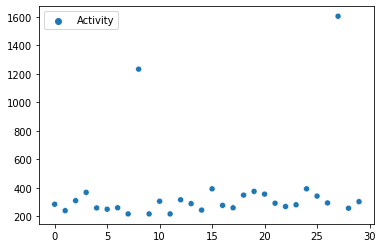

In [15]:
subjects_sorted = subjects_count.sort_index()
sns.scatterplot(data=subjects_sorted)
plt.show()

In [16]:
subjects_groups["subject"].nunique()

30

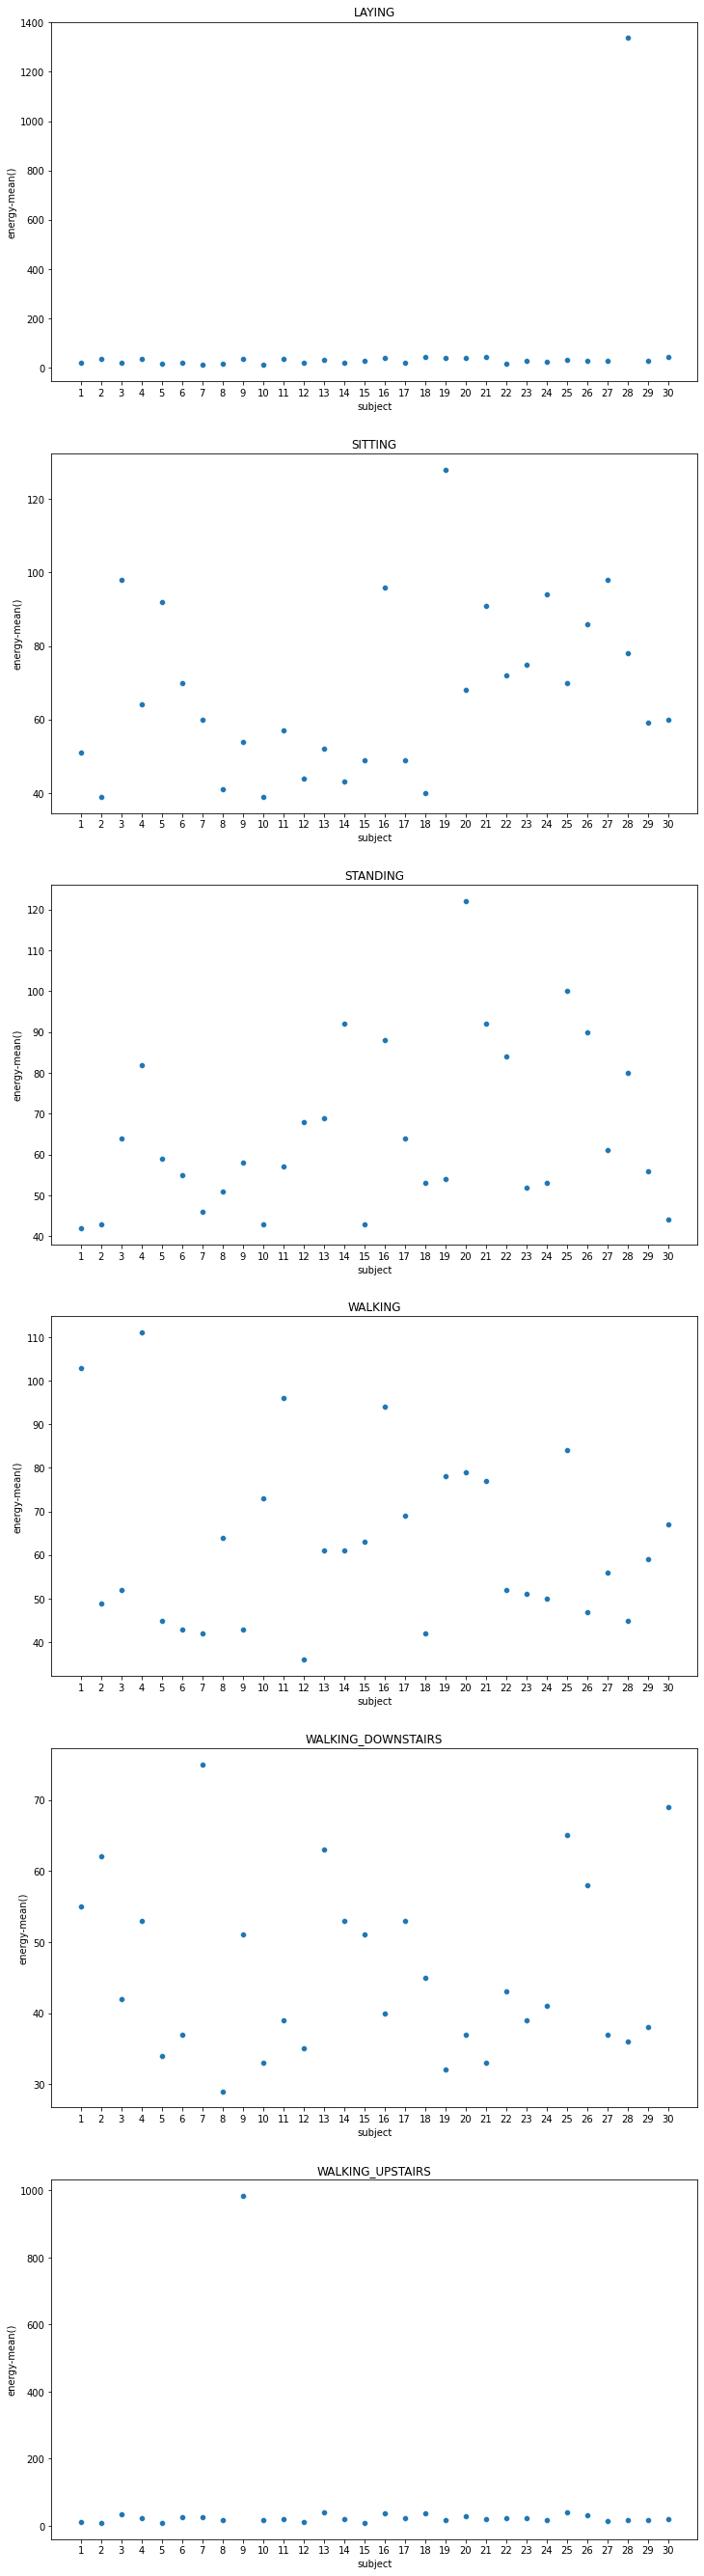

In [18]:
n = len(subjects_groups["Activity"].unique())

fix, ax = plt.subplots(n, 1, figsize=(12, len(subjects_groups["Activity"].unique())*8))

for axi, activity in zip(ax, subjects_groups["Activity"].unique()):
    sns.scatterplot(x="subject", y="energy-mean()", data=subjects_groups[subjects_groups["Activity"]==activity], ax=axi)
    axi.set_xticks(np.arange(1, subjects_groups["subject"].nunique()+1))
    axi.set_title(activity)

plt.show()

In [19]:
subjects_groups

,subject,Activity,energy-mean()
0,1,LAYING,19
1,1,SITTING,51
2,1,STANDING,42
3,1,WALKING,103
4,1,WALKING_DOWNSTAIRS,55
...,...,...,...
175,30,SITTING,60
176,30,STANDING,44
177,30,WALKING,67
178,30,WALKING_DOWNSTAIRS,69


### Data imputation

In [82]:
data.shape

(9624, 572)

Reorder data to get subject and activity on the end

In [82]:
columns = list(X_sample.columns)
columns.remove("subject")
columns.extend(["subject"])

X_sample = X_sample[columns]

Get dummies

In [83]:
X_w_dummies = pd.get_dummies(X_sample, columns=["subject"], drop_first=True)
X_w_dummies[X_w_dummies.columns[-30:]].head(2)

,void,subject_2,subject_3,subject_4,subject_5,subject_6,subject_7,subject_8,subject_9,subject_10,subject_11,subject_12,subject_13,subject_14,subject_15,subject_16,subject_17,subject_18,subject_19,subject_20,subject_21,subject_22,subject_23,subject_24,subject_25,subject_26,subject_27,subject_28,subject_29,subject_30
10518,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5748,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [20]:
imputer = KNNImputer(n_neighbors=5, weights="distance")
for subject in data["subject"].unique():
    X.loc[X["subject"]==subject, :] = imputer.fit_transform(X.loc[X["subject"]==subject, :])

### Euclidean
Calucluating euclidean distance as magnitude of force

In [75]:
xyz_bands_energy = np.array(sorted([column for column in X.columns if "bandsEnergy" in column])).reshape(-1, 3)

In [106]:
[col.split("-")[2].split(",") for col in xyz_bands_energy.flatten().tolist()]

[['1', '16'],
 ['1', '16.1'],
 ['1', '16.2'],
 ['1', '24'],
 ['1', '24.1'],
 ['1', '24.2'],
 ['1', '8'],
 ['1', '8.1'],
 ['1', '8.2'],
 ['17', '24'],
 ['17', '24.1'],
 ['17', '24.2'],
 ['17', '32'],
 ['17', '32.1'],
 ['17', '32.2'],
 ['25', '32'],
 ['25', '32.1'],
 ['25', '32.2'],
 ['25', '48'],
 ['25', '48.1'],
 ['25', '48.2'],
 ['33', '40'],
 ['33', '40.1'],
 ['33', '40.2'],
 ['33', '48'],
 ['33', '48.1'],
 ['33', '48.2'],
 ['41', '48'],
 ['41', '48.1'],
 ['41', '48.2'],
 ['49', '56'],
 ['49', '56.1'],
 ['49', '56.2'],
 ['49', '64'],
 ['49', '64.1'],
 ['49', '64.2'],
 ['57', '64'],
 ['57', '64.1'],
 ['57', '64.2'],
 ['9', '16'],
 ['9', '16.1'],
 ['9', '16.2'],
 ['1', '16'],
 ['1', '16.1'],
 ['1', '16.2'],
 ['1', '24'],
 ['1', '24.1'],
 ['1', '24.2'],
 ['1', '8'],
 ['1', '8.1'],
 ['1', '8.2'],
 ['17', '24'],
 ['17', '24.1'],
 ['17', '24.2'],
 ['17', '32'],
 ['17', '32.1'],
 ['17', '32.2'],
 ['25', '32'],
 ['25', '32.1'],
 ['25', '32.2'],
 ['25', '48'],
 ['25', '48.1'],
 ['25', '48.2']

In [76]:
X_euclid = X.copy()

In [77]:
for xyz in xyz_bands_energy:
    X_euclid[f"{xyz[0]}_euclid"] = (X_euclid[xyz] ** 2).sum(axis=1)
    X_euclid.drop(columns=xyz, inplace=True)

In [78]:
xyz_bands_energy = np.array(sorted([column for column in X.columns if "bandsEnergy" in column])).reshape(-1, 3)

### Scale data

In [79]:
scaler = StandardScaler()
subjects = X_euclid["subject"].copy()

columns = X_euclid.columns
X_euclid = scaler.fit_transform(X_euclid)

X_euclid = pd.DataFrame(X_euclid, columns=columns)
X_euclid["subject"] = subjects

### Spliting dataset

In [80]:
y.unique().categories

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

In [81]:
mapping = {cat:idx for idx, cat in enumerate(y.unique().categories)}

In [82]:
y = y.map(mapping)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_euclid, y, test_size=0.2)

### Training

In [84]:
cat_features = ["subject"]

In [85]:
classifier = catboost.CatBoostClassifier(task_type="GPU", devices="0")

In [86]:
classifier.fit(X_train, y_train, cat_features=cat_features, verbose=0)

In [87]:
y_hat = classifier.predict(X_test)

In [88]:
from sklearn.metrics import confusion_matrix

In [89]:
mapping

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [90]:
confusion_matrix(y_test, y_hat)

array([[400,   0,   0,   0,   1,   0],
       [  0, 318,   0,   0,   0,   1],
       [  0,   0, 436,   0,   0,   0],
       [  0,   0,   0, 358,   0,   1],
       [  6,   0,   0,   0, 426,   0],
       [  0,   0,   0,   0,   0, 271]])

In [91]:
from sklearn.metrics import plot_confusion_matrix

Confusion matrix, without normalization
Normalized confusion matrix


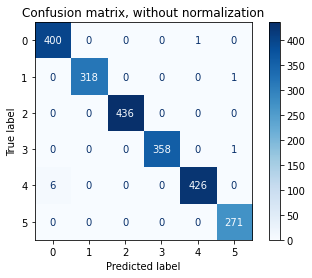

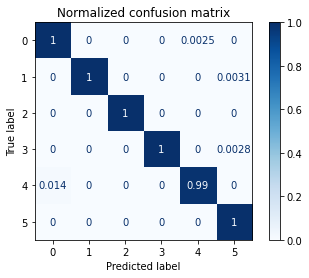

In [92]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=mapping.keys(),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
#     print(disp.confusion_matrix)

plt.show()

In [93]:
from sklearn.metrics import accuracy_score

In [94]:
accuracy_score(y_test, y_hat)

0.9959422903516681

In [95]:
len(X_euclid.columns)

486